# Задание 
Попробуйте обучить методом Transfer Learning одну из готовых архитектур 
* ResNet, 
* VGG,
* etc. 

используя датасет кошки против собак - 

https://www.microsoft.com/en-us/download/details.aspx?id=54765
или
https://www.kaggle.com/c/dogs-vs-cats/data

## Import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-10-18 18:27:41.061739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 18:27:41.185955: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-18 18:27:41.211136: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 18:27:41.699192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-10-18 18:27:42.523465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-18 18:27:42.528921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-18 18:27:42.528977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Подготовка данных

In [3]:
import glob
imgs_cat = glob.glob("PetImages/Cat/*.jpg")
imgs_dog = glob.glob("PetImages/Dog/*.jpg")
print(imgs_count := len(imgs_cat) + len(imgs_dog))

25000


In [4]:
cat_df = pd.DataFrame({'filename':imgs_cat, 'label':"cat"})
dog_df = pd.DataFrame({'filename':imgs_dog, 'label':"dog"})
total_df = pd.concat([cat_df, dog_df], ignore_index=True)
display(total_df)

,filename,label
0,PetImages/Cat/3661.jpg,cat
1,PetImages/Cat/7736.jpg,cat
2,PetImages/Cat/12352.jpg,cat
3,PetImages/Cat/9805.jpg,cat
4,PetImages/Cat/957.jpg,cat
...,...,...
24995,PetImages/Dog/4504.jpg,dog
24996,PetImages/Dog/1505.jpg,dog
24997,PetImages/Dog/5701.jpg,dog
24998,PetImages/Dog/4563.jpg,dog


### Визуализация

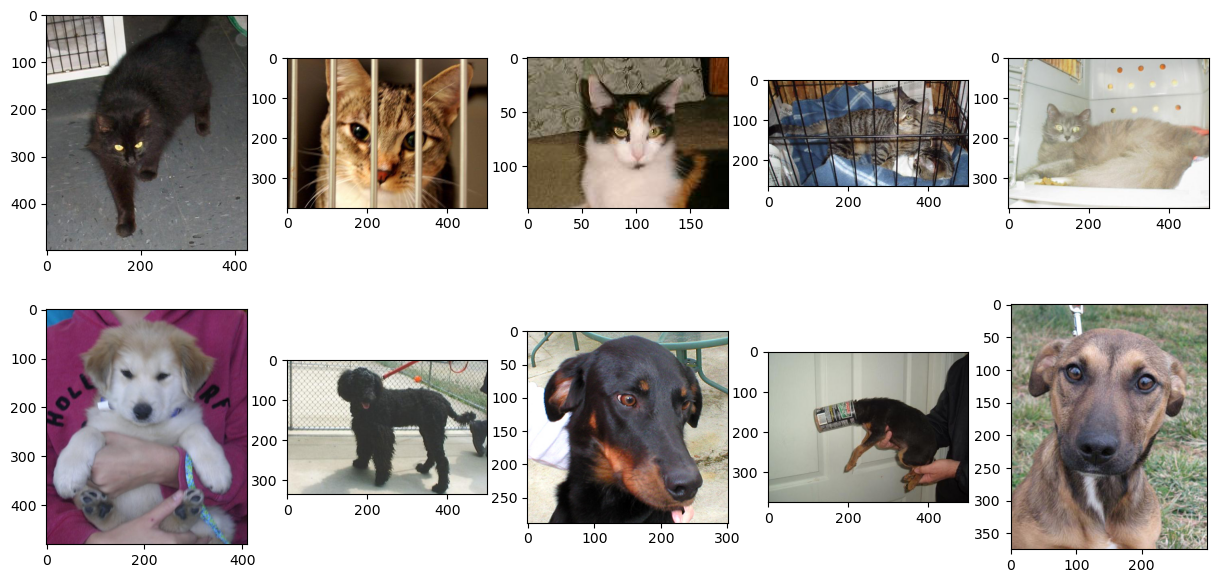

In [5]:
plt.figure(figsize=(15,7))
for i, c in enumerate(np.random.randint(0,len(cat_df),5), start=1):
    im = img.imread(cat_df.loc[c, 'filename'])
    plt.subplot(2,5,i)
    plt.imshow(im)
    
for i, c in enumerate(np.random.randint(0,len(dog_df),5), start=6):
    im = img.imread(dog_df.loc[c, 'filename'])
    plt.subplot(2,5,i)
    plt.imshow(im)

### Разбиение на тренировочную и проверочную выборку

In [6]:
train_set, valid_set = train_test_split(total_df, test_size=0.2)
print(f"Train set shape {train_set.shape}")
print(f"Validation set shape {train_set.shape}")

Train set shape (20000, 2)
Validation set shape (20000, 2)


In [7]:
print(f"Train set distribution: \n{train_set['label'].value_counts()}")
print(f"\nValidation set distribution: \n{valid_set['label'].value_counts()}")


Train set distribution: 
cat    10032
dog     9968
Name: label, dtype: int64

Validation set distribution: 
dog    2532
cat    2468
Name: label, dtype: int64


### Дата генератор

In [8]:
WIDTH, HEIGHT = 150, 150 # для нормирование размера изображения
batch_size = 32

In [9]:
train_datagenerator = ImageDataGenerator(rotation_range=15, 
                                  rescale=1./255, 
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

train_data = train_datagenerator.flow_from_dataframe(dataframe=train_set, 
                                                       x_col='filename',
                                                       y_col='label',
                                                       target_size=(WIDTH, HEIGHT),
                                                       class_mode='categorical',
                                                       batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [10]:
test_datagenerator = ImageDataGenerator(rotation_range=15, 
                                  rescale=1./255, 
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

test_data = test_datagenerator.flow_from_dataframe(dataframe=train_set, 
                                                       x_col='filename',
                                                       y_col='label',
                                                       target_size=(WIDTH, HEIGHT),
                                                       class_mode='categorical',
                                                       batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


## Модель

In [11]:
def createTLNN():
    model = Sequential()
    
    modelTL = tf.keras.applications.vgg19.VGG19(input_shape = (WIDTH, HEIGHT, 3), include_top = False, weights = 'imagenet')
    modelTL.trainable = False
    model.add(modelTL)

    model.add(L.Flatten()) #2048
    model.add(L.Dense(128, activation='relu'))
    model.add(L.Dropout(0.2))
    model.add(L.Dense(2, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
model = createTLNN()


2022-10-18 18:27:44.332185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 18:27:44.335264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-18 18:27:44.335461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-18 18:27:44.335519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may h

In [13]:
model.fit(train_data)

2022-10-18 18:27:47.397817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-18 18:27:48.132965: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-18 18:27:48.216985: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-18 18:27:48.217092: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-18 18:27:48.287291: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-18 18:27:48.287516: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  2/625 [..............................] - ETA: 33s - loss: 0.7177 - accuracy: 0.5781  

2022-10-18 18:27:51.749971: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


457/625 [====================>.........] - ETA: 23s - loss: 0.3977 - accuracy: 0.8107

/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


478/625 [=====================>........] - ETA: 20s - loss: 0.3954 - accuracy: 0.8120

2022-10-18 18:28:58.841280: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f4991b0bf40>
Traceback (most recent call last):

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 1050, 

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f4991b0bf40>
Traceback (most recent call last):

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/image_utils.py", line 423, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py", line 3147, in open
    raise UnidentifiedImageError(

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f4991b0bf40>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f4991b0bf40>
Traceback (most recent call last):

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/image_utils.py", line 423, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py", line 3147, in open
    raise UnidentifiedImageError(

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f4991b0bf40>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1689]